In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from google.colab import drive
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive')
os.chdir('//content/drive/MyDrive/1. Educ/1. Masters/Year 1/ICS5110 - Applied Machine Learning/1. Personal Assignment/Git Repo/applied_ml_assignment')
print(os.getcwd())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/1. Educ/1. Masters/Year 1/ICS5110 - Applied Machine Learning/1. Personal Assignment/Git Repo/applied_ml_assignment


In [2]:
#Loading cleaned data from CVS
training_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
# validation_data = pd.read_csv("data/validate_data.csv")

training_data['Date'] = pd.to_datetime(training_data['Date'])

display(training_data.head(5))

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k,tmin,tavg,tmax
0,2003-01-01,0.36,182.08,0.0,0.0,0.0,4.8200,398.580000,10.9,13.2,15.6
1,2003-02-01,0.40,187.10,0.0,0.0,0.0,4.8275,398.580000,7.9,10.4,13.0
2,2003-03-01,0.34,176.37,0.0,0.0,0.0,4.8350,398.804167,9.8,12.7,15.7
3,2003-04-01,0.30,156.53,0.0,0.0,0.0,4.8425,399.028333,12.4,15.5,18.7
4,2003-05-01,0.28,163.97,0.0,0.0,0.0,4.8500,399.252500,16.0,20.4,24.8


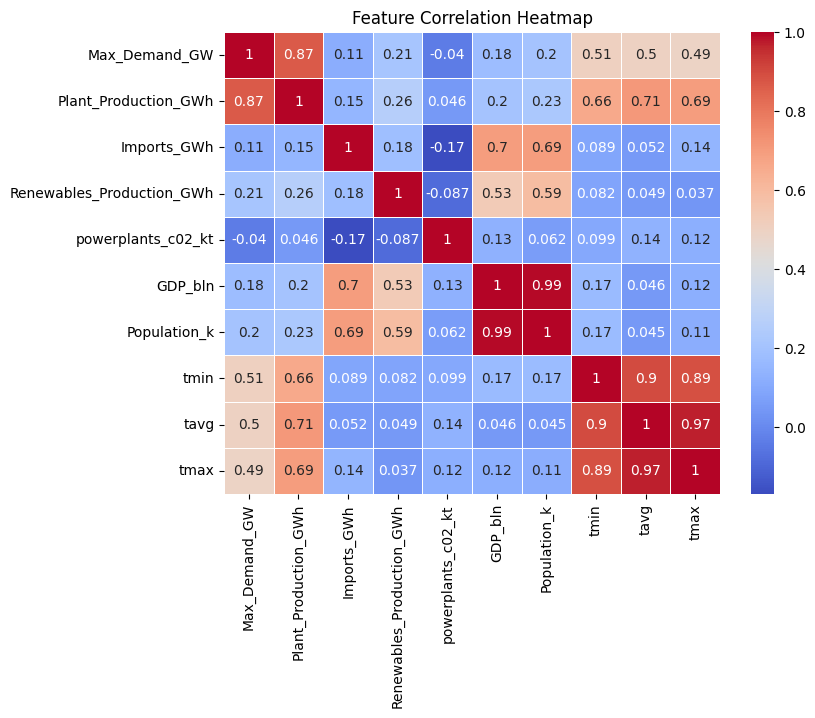

In [3]:
#Building correlation matrices to understand dataset and features
featuresToDrop = ['Date']
correlation_matrix = training_data.drop(columns=featuresToDrop).corr()

# Plot a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

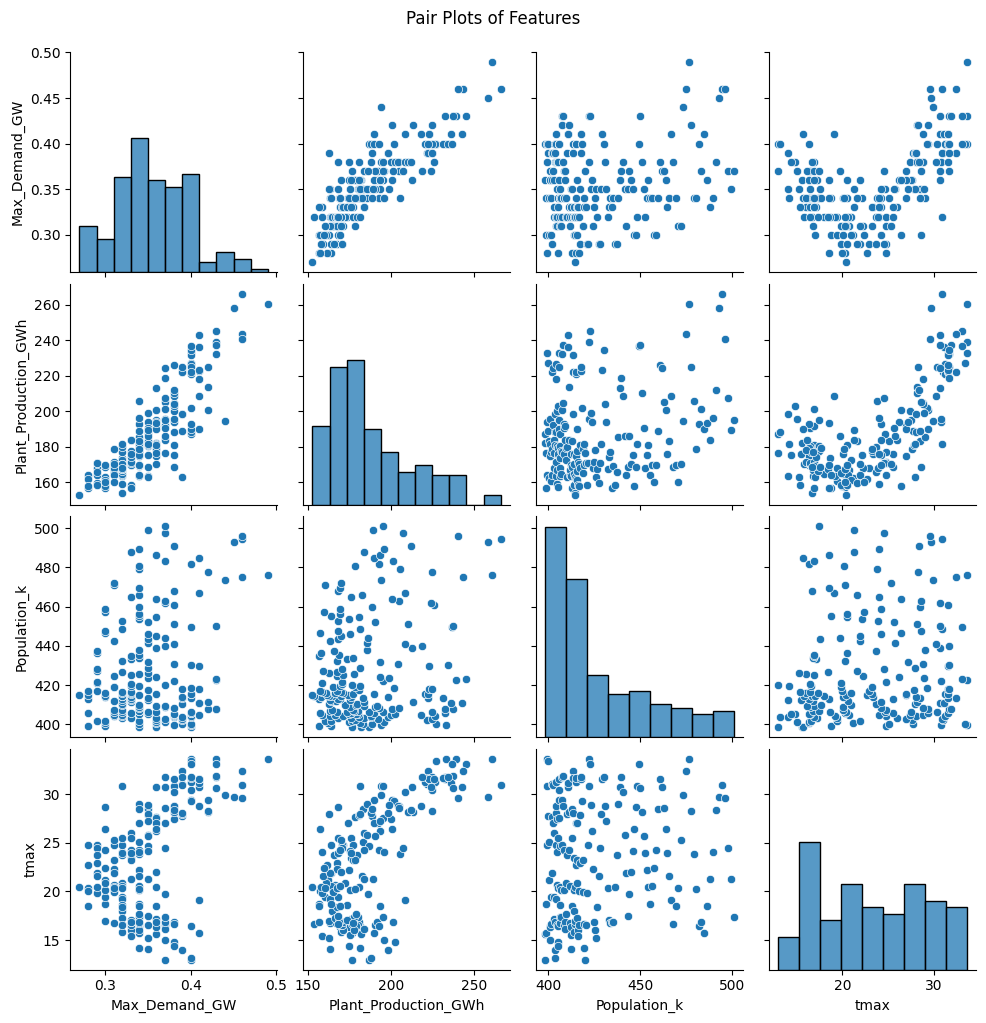

In [4]:
# Extract features excluding the below items
featuresToDrop = ['GDP_bln', 'tmin', 'tavg', 'powerplants_c02_kt', 'Renewables_Production_GWh','Imports_GWh']
datasetToPlot = training_data.drop(columns=featuresToDrop)
selected_features = datasetToPlot.columns[1:]

# Create pair plots using Seaborn
sns.pairplot(training_data[selected_features])
plt.suptitle('Pair Plots of Features', y=1.02)
plt.show()


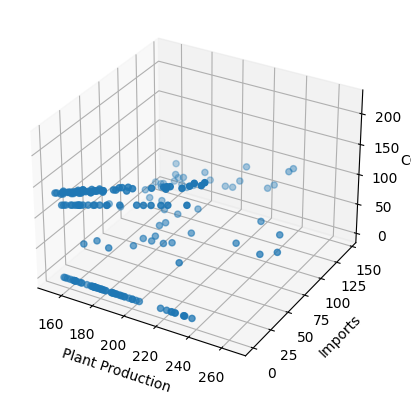

In [5]:
#Analyzing CO2 vs Production vs Imports
# Creating the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = training_data['Plant_Production_GWh']
y = training_data['Imports_GWh']
z = training_data['powerplants_c02_kt']

# # Scatter plot
ax.scatter(x, y, z)
# ax.view_init(elev=30, azim=120)

# # Set labels
ax.set_xlabel('Plant Production')
ax.set_ylabel('Imports')
ax.set_zlabel('CO2')
# Show plot
plt.show()


In [6]:
# Create a Plotly trace for a 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Color by z-value for example
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Plant Production'),
        yaxis=dict(title='Imports'),
        zaxis=dict(title='CO2')
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [7]:
# Create a Plotly trace for a 3D scatter plot
trace = go.Scatter3d(
    x=training_data['tmax'],
    y=training_data['Population_k'],
    z=training_data['Max_Demand_GW'],
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Color by z-value for example
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='tmax'),
        yaxis=dict(title='population'),
        zaxis=dict(title='max_demand')
    )
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

The model produced by support vector classification depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.



Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline

https://scikit-learn.org/stable/modules/svm.html

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVR was fitted without feature names



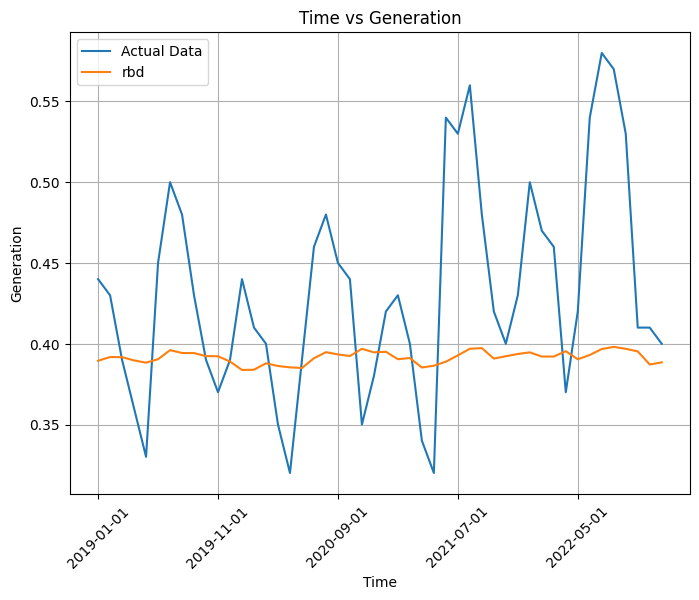

Mean Squared Error: 0.005707680664153167


In [8]:
selectedFeatures = ['GDP_bln','tmax', 'Population_k','Renewables_Production_GWh','Imports_GWh']
selectedTarget = ['Max_Demand_GW']

x_ToTrain = training_data[selectedFeatures]
y_ToTrain = training_data[selectedTarget]

x_ToTest = test_data[selectedFeatures]
y_ToTest = test_data[selectedTarget]

x_ToTrain = x_ToTrain.to_numpy()
y_ToTrain = y_ToTrain.to_numpy().ravel()

svm_regressor = SVR(kernel='rbf', C=2, gamma='scale')  # You can specify different kernels like 'linear', 'poly', 'rbf', etc.
svm_regressor.fit(x_ToTrain, y_ToTrain)

# Making predictions
y_pred = svm_regressor.predict(x_ToTest)

# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(test_data['Date'], y_ToTest, linestyle='-', label="Actual Data")
plt.plot(test_data['Date'], y_pred, linestyle='-', label = "rbd")

n = 10
plt.xticks(np.arange(0, len(test_data['Date']), n), [test_data['Date'][i] for i in range(0, len(test_data['Date']), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

# Evaluating the model (example using Mean Squared Error)
mse = mean_squared_error(y_ToTest, y_pred)
print(f"Mean Squared Error: {mse}")

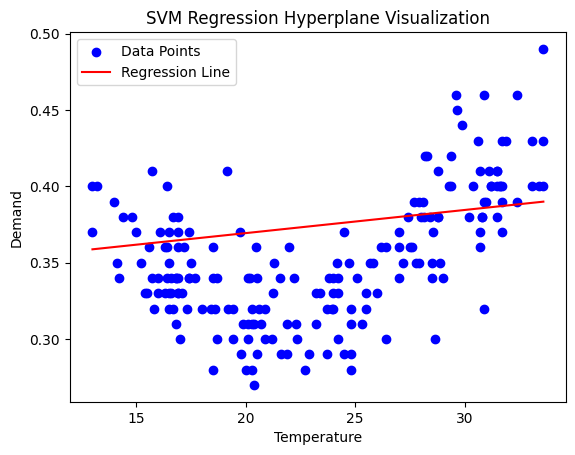

In [9]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_ToTrain = training_data[selectedFeatures]
y_ToTrain = training_data[selectedTarget]

x_ToTrain = x_ToTrain.to_numpy()
y_ToTrain = y_ToTrain.to_numpy().ravel()

# Creating and fitting the SVM regression model
svm = SVR(kernel='linear', C=1.0)
svm.fit(x_ToTrain, y_ToTrain)

# Get the weights and bias term
w = svm.coef_[0]
b = svm.intercept_[0]

# Plotting the data points
plt.scatter(x_ToTrain, y_ToTrain, c='blue', label='Data Points')

# Plotting the hyperplane
x_values = np.linspace(np.min(x_ToTrain), np.max(x_ToTrain), 100)
y_values = w * x_values + b

plt.plot(x_values, y_values, color='red', label='Regression Line')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression Hyperplane Visualization')
plt.legend()
plt.show()

The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.




Gamma Range:
Small Gamma:

gamma < 1: A smaller gamma implies a larger range of influence for each support vector. The decision boundary tends to be smoother, and the model might generalize better.
Large Gamma:

gamma > 1: A larger gamma shrinks the range of influence of support vectors, making the decision boundary more 'wiggly' to fit closely to individual data points.
gamma = 'auto' or 'scale': In scikit-learn, 'auto' or 'scale' settings automatically set the value of gamma. 'auto' uses 1/n_features, and 'scale' uses 1/(n_features * X.var()).
Impact:
Higher gamma: Can lead to overfitting, especially with smaller datasets or noisy data, as the model might adapt too closely to the training data.
Lower gamma: Tends to produce smoother decision boundaries, aiding in better generalization to unseen data.



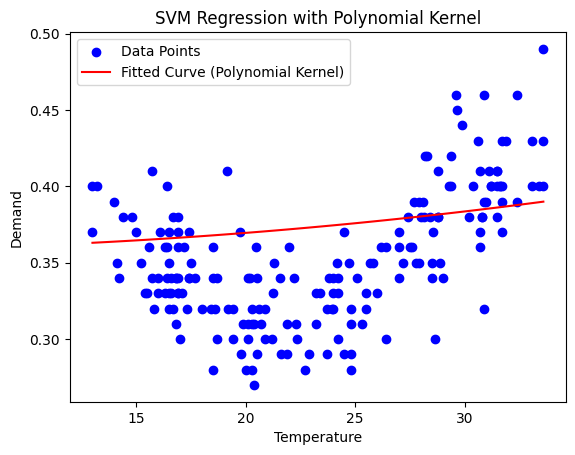

In [10]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_poly = training_data[selectedFeatures]
y_poly = training_data[selectedTarget]

x_poly = x_poly.to_numpy()
y_poly = y_poly.to_numpy().ravel()

# Creating and fitting the SVM regression model with a polynomial kernel
svm_poly = SVR(kernel='poly', degree=2, C=10, gamma='auto')
svm_poly.fit(x_poly, y_poly)

# Plotting the data points
plt.scatter(x_poly, y_poly, c='blue', label='Data Points')

# Plotting the predicted curve
x_values = np.linspace(np.min(x_poly), np.max(x_poly), 100)
y_values = svm_poly.predict(x_values.reshape(-1, 1))  # Reshaping for prediction

plt.plot(x_values, y_values, color='red', label='Fitted Curve (Polynomial Kernel)')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression with Polynomial Kernel')
plt.legend()
plt.show()

**Normalizing**

**Standardization (Z-score normalization):**
Method: Subtract the mean and scale by the standard deviation for each feature.
Benefits: Useful when features have different units or different ranges.

**Min-Max Scaling (Normalization):**
Method: Scale features to a specific range, often [0, 1].
Benefits: Useful when algorithms require inputs to be in a specific range.

**Robust Scaling:**
Method: Scale features using median and interquartile range (IQR) to make them robust to outliers.
Benefits: Useful when data contains outliers.

**Log Transformation:**
Method: Apply logarithmic transformation to the data to handle skewed distributions or to emphasize relative changes.
Benefits: Useful when the data is heavily skewed.

**Which to Choose:**
Use standardization (StandardScaler in scikit-learn) when features have varying scales and roughly Gaussian-like distributions.
Use min-max scaling (MinMaxScaler in scikit-learn) when the algorithm requires input in a specific range.
Use robust scaling (RobustScaler in scikit-learn) when the dataset contains outliers.
Use log transformation if the data has a heavily skewed distribution.


ChatGPT

In [11]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x = training_data[selectedFeatures]
y_norm = training_data[selectedTarget]

scaler = StandardScaler()  # Or use MinMaxScaler, RobustScaler, etc.
x_norm= scaler.fit_transform(x)
y_norm = y_norm.to_numpy().ravel()

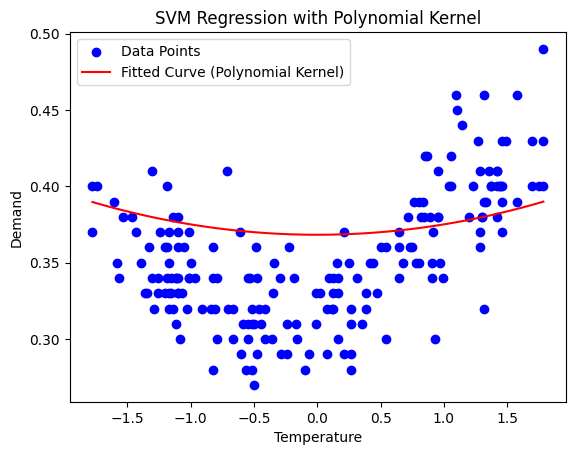

In [12]:
# Creating and fitting the SVM regression model with a polynomial kernel
svm_poly_norm = SVR(kernel='poly', degree=2, C=10, gamma='auto') #can use scale
svm_poly_norm.fit(x_norm, y_norm)

# Plotting the data points
plt.scatter(x_norm, y_norm, c='blue', label='Data Points')

# Plotting the predicted curve
x_values = np.linspace(np.min(x_norm), np.max(x_norm), 100)
y_values = svm_poly_norm.predict(x_values.reshape(-1, 1))  # Reshaping for prediction

plt.plot(x_values, y_values, color='red', label='Fitted Curve (Polynomial Kernel)')

plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('SVM Regression with Polynomial Kernel')
plt.legend()
plt.show()

In [13]:
# selectedFeatures = ['GDP_bln','tmax', 'Population_k']
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']
scaler = StandardScaler()  # Or use MinMaxScaler, RobustScaler, etc.

x_normTrain= scaler.fit_transform(training_data[selectedFeatures])
y_normTrain = training_data[selectedTarget].to_numpy().ravel()

x_normTest = scaler.fit_transform(test_data[selectedFeatures])
y_normTest = test_data[selectedTarget].to_numpy().ravel()

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

https://scikit-learn.org/stable/modules/svm.html

In [14]:
# Define the parameter grid to search through
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create the SVR model
svm_regressor = SVR(kernel='rbf')

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV instance on your data
grid_search.fit(x_normTrain, y_normTrain)

# Retrieve the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Negative MSE:", best_score)

Best Parameters: {'C': 0.1, 'gamma': 0.1}
Best Negative MSE: -0.0022010134921927682


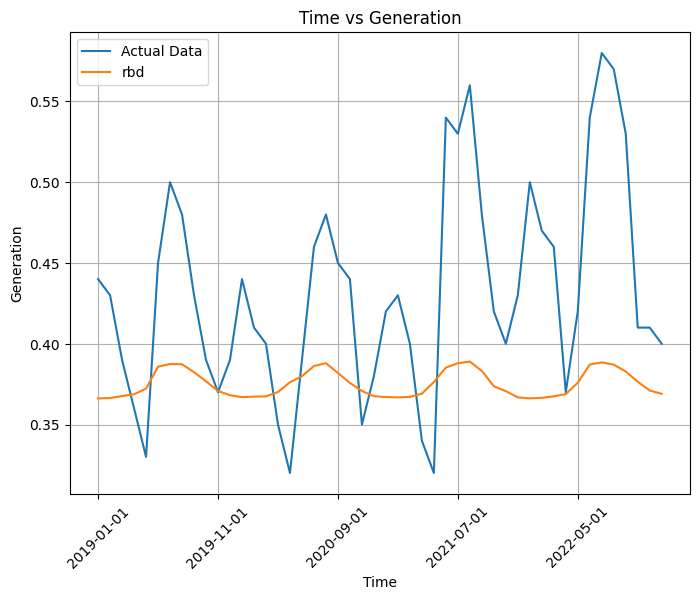

Mean Squared Error: 0.006975930140595763


In [15]:
svm_regressor = SVR(kernel='rbf', C=0.1, gamma=0.1)
svm_regressor.fit(x_normTrain, y_normTrain)

# Making predictions
y_pred = svm_regressor.predict(x_normTest)

# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(test_data['Date'], y_normTest, linestyle='-', label="Actual Data")
plt.plot(test_data['Date'], y_pred, linestyle='-', label = "rbd")

n = 10
plt.xticks(np.arange(0, len(test_data['Date']), n), [test_data['Date'][i] for i in range(0, len(test_data['Date']), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

# Evaluating the model (example using Mean Squared Error)
mse = mean_squared_error(y_ToTest, y_pred)
print(f"Mean Squared Error: {mse}")

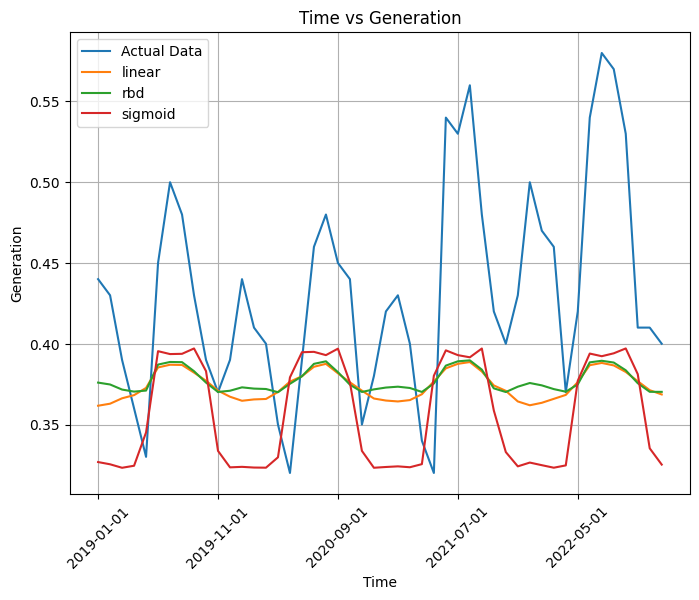

In [16]:
selectedFeatures = ['tmax']
selectedTarget = ['Max_Demand_GW']

x_Time = test_data['Date']
y_Test = test_data[selectedTarget]

model_linear = SVR(kernel='linear')
model_linear.feature_names = selectedFeatures
model_linear.fit(x_normTrain, y_normTrain)
y_pred_linear = model_linear.predict(x_normTest)


model_poly = SVR(kernel='poly', degree=2, C=0.1, gamma=0.1)
model_poly.feature_names = selectedFeatures
model_poly.fit(x_normTrain, y_normTrain)
y_pred_poly = model_poly.predict(x_normTest)


model_rbf = SVR(kernel='rbf', gamma='scale')
model_rbf.feature_names = selectedFeatures
model_rbf.fit(x_normTrain, y_normTrain)
y_pred_rbf = model_rbf.predict(x_normTest)

model_sigmoid = SVR(kernel='sigmoid', gamma='scale')
model_sigmoid.feature_names = selectedFeatures
model_sigmoid.fit(x_normTrain, y_normTrain)
y_pred_sigmoid = model_sigmoid.predict(x_normTest)


# Plotting the feature vs target curve
plt.figure(figsize=(8, 6))
plt.plot(x_Time, y_normTest, linestyle='-', label="Actual Data")
plt.plot(x_Time, y_pred_linear, linestyle='-', label="linear")
# plt.plot(x_Time, y_pred_poly, linestyle='-', label = "poly")
plt.plot(x_Time, y_pred_rbf, linestyle='-', label = "rbd")
plt.plot(x_Time, y_pred_sigmoid, linestyle='-', label="sigmoid")

n = 10
plt.xticks(np.arange(0, len(x_Time), n), [x_Time[i] for i in range(0, len(x_Time), n)])

plt.title('Time vs Generation')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Generation')
plt.grid(True)
plt.legend()
plt.show()

 SelectFromModel using an SVR (Support Vector Regression) model with importance_getter='auto' - the feature selector is expecting the underlying estimator (in this case, the SVR model) to have either coef_ or feature_importances_ attribute available for feature selection.

**In the case of SVR, it doesn't have a coef_ attribute by default, as it doesn't provide direct coefficients like linear regression. SVR relies on support vectors, not coefficients, for prediction.**

To resolve:

Selecting an Attribute Manually:

Specify the attribute explicitly using importance_getter to access specific properties from the SVR model. For instance, you could set importance_getter='coef_' if you're looking for coefficients, although SVR doesn't provide direct coefficients.

Use a Different Feature Selector:

Consider using other feature selection methods that are not dependent on coef_ or feature_importances_. For SVR, *Recursive Feature Elimination (RFE)* or Sequential Feature Selection might be more appropriate.
Manually Extracting Feature Importance:

For SVR, calculate or derive feature importance using other techniques specific to the problem domain or by analyzing the support vectors' influence on predictions.

In [17]:
selectedFeaturesToTest = ['tmax','tmin','tavg', 'Population_k','powerplants_c02_kt', 'Plant_Production_GWh' ]
selectedTargetToTest = ['Max_Demand_GW']

x_getFeatures = training_data[selectedFeaturesToTest]
y_getFeatures = training_data[selectedTargetToTest]

x_getFeatures = x_getFeatures.to_numpy()
y_getFeatures = y_getFeatures.to_numpy().ravel()

svr = SVR(kernel='linear')
svr.fit(x_getFeatures, y_getFeatures)

# Initialize RFE
rfe = RFE(estimator=svr, n_features_to_select=3)  # Choose the number of features you want to select

# Fit RFE
rfe.fit(x_getFeatures, y_getFeatures)

# Selected features
X_selected = rfe.transform(x_getFeatures)
# display(X_selected)